In [19]:
pip install duckdb


In [45]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from google.cloud import aiplatform
import joblib
import duckdb
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc


# GCP Setup
PROJECT_ID = "your-gcp-project"
REGION = "us-central1"
BUCKET_NAME = "your-gcs-bucket"
MODEL_DISPLAY_NAME = "advanced_fraud_detector"

In [16]:
csv_path='/content/Fraud_Detection_Dataset.csv'
df = pd.read_csv(csv_path, parse_dates=["transaction_time"])
df.sort_values(by='transaction_time').head()

,transaction_id,user_id,transaction_amount,merchant_id,transaction_type,channel,transaction_time,ip_address,device_id,location,...,account_age_days,user_has_2fa_enabled,email_verified,credit_score,kyc_verified,velocity_within_session,card_present,is_first_transaction,is_fraud,transaction_hour
151,dbfa4712-b49a-4eec-b592-85f2be74f97b,user_18,11.07,merchant_20,POS,Web,2025-03-18 14:31:03,34.36.172.118,device_58,"Robertberg, BD",...,781,0,1,762,0,2,0,0,0,14
212,86adb915-24d1-44a4-a4c4-ef400add1d48,user_10,98.09,merchant_15,Online,In-Store,2025-03-18 14:47:47,8.25.4.114,device_5,"Ashleyburgh, EC",...,917,1,1,835,1,1,1,0,0,14
209,678d1bb4-e565-4063-a0ab-9ab58d928fdb,user_6,325.89,merchant_18,POS,In-Store,2025-03-18 15:40:26,124.77.60.44,device_5,"Lake Ashley, KW",...,631,0,1,653,1,1,1,0,0,15
36,cc6b0bd3-e896-4576-8676-98d62df577fd,user_11,25.01,merchant_16,POS,Web,2025-03-18 17:12:39,198.9.251.58,device_2,"East Janicestad, EE",...,508,0,1,416,1,2,1,0,0,17
256,be62fb37-d994-4d6a-92be-c76b5d78cc14,user_28,118.19,merchant_5,Withdrawal,Web,2025-03-18 17:51:12,6.33.154.88,device_5,"Kennethburgh, BW",...,277,1,0,452,1,2,1,0,0,17


In [6]:
df['is_fraud'].value_counts()/df.shape[0]*100

,count
is_fraud,
0,94.2
1,5.8


### Preprocessing and Feature Engineering

Understanding how to identify fraudulent behavior is crucial. Below are several variables developed based on insights from various sources, aimed at highlighting patterns commonly associated with fraudulent users.


**transaction_count_7d:**
High frequency of transactions in a short period may indicate account takeover or bot activity.

 **avg_transaction_amount_7d:**
A sudden drop or spike in average amount can signal unusual spending behavior or test transactions.

**max_transaction_amount_7d:**
Detects unusually large transactions that may suggest a fraudster is trying to extract maximum value.

**total_spent_7d:**
Tracks cumulative spending—suspiciously high spending in a short window can be a red flag.

**unique_merchants_7d:**
A sharp increase in distinct merchants may suggest card testing or laundering through many vendors

In [20]:


# Sample: your existing DataFrame is called `df`
# Ensure proper datetime format
df["transaction_time"] = pd.to_datetime(df["transaction_time"])
df["transaction_date"] = df["transaction_time"].dt.date
df["transaction_hour"] = df["transaction_time"].dt.hour

# Register the DataFrame in DuckDB
con = duckdb.connect()
con.register("transactions", df)

# Execute SQL query to compute rolling 7-day metrics
query = """
SELECT
    *,
    COUNT(*) OVER (
        PARTITION BY user_id
        ORDER BY transaction_time
        RANGE BETWEEN INTERVAL 7 DAY PRECEDING AND CURRENT ROW
    ) AS transaction_count_7d,

    AVG(transaction_amount) OVER (
        PARTITION BY user_id
        ORDER BY transaction_time
        ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
    ) AS avg_transaction_amount_7d,

    MAX(transaction_amount) OVER (
        PARTITION BY user_id
        ORDER BY transaction_time
        ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
    ) AS max_transaction_amount_7d,

    SUM(transaction_amount) OVER (
        PARTITION BY user_id
        ORDER BY transaction_time
        ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
    ) AS total_spent_7d
FROM transactions
"""

df = con.execute(query).fetchdf()


In [21]:
df.head()

,transaction_id,user_id,transaction_amount,merchant_id,transaction_type,channel,transaction_time,ip_address,device_id,location,...,velocity_within_session,card_present,is_first_transaction,is_fraud,transaction_hour,transaction_date,transaction_count_7d,avg_transaction_amount_7d,max_transaction_amount_7d,total_spent_7d
0,e529c8f8-9b2f-490b-a9fa-1cd8b4f288ec,user_21,256.92,merchant_1,POS,In-Store,2025-03-21 18:14:45,91.51.6.239,device_79,"Thomastown, EC",...,3,0,0,1,18,2025-03-21,1,256.920,256.92,256.92
1,84a48f33-2e9c-483e-977f-04da86fa7d21,user_21,10.39,merchant_20,Withdrawal,Web,2025-03-25 01:04:57,111.74.248.103,device_54,"East Ronaldhaven, FJ",...,3,0,0,0,1,2025-03-25,2,133.655,256.92,267.31
2,c6bf6ddc-e3ce-4f7a-b67b-d55c619e1044,user_21,0.23,merchant_15,POS,Web,2025-03-28 09:23:23,58.236.181.151,device_78,"Lake Anaburgh, SI",...,5,0,0,1,9,2025-03-28,3,89.180,256.92,267.54
3,1dc1b3c7-35d4-4027-bfd2-3a23296eedce,user_21,341.36,merchant_8,Transfer,In-Store,2025-03-31 23:55:49,75.131.134.31,device_62,"Nataliebury, PT",...,3,0,0,1,23,2025-03-31,3,152.225,341.36,608.90
4,d4954f0a-8e7a-43ac-9b2c-ba7814b264ed,user_21,104.95,merchant_5,Transfer,Mobile App,2025-04-04 15:19:57,83.160.128.249,device_77,"Jasonberg, IQ",...,4,0,0,0,15,2025-04-04,2,142.770,341.36,713.85


In [37]:
def load_and_engineer_features(csv_path):
  df = pd.read_csv(csv_path, parse_dates=["transaction_time"])



# Sample: your existing DataFrame is called `df`
# Ensure proper datetime format
  df["transaction_time"] = pd.to_datetime(df["transaction_time"])
  df["transaction_date"] = df["transaction_time"].dt.date
  df["transaction_hour"] = df["transaction_time"].dt.hour

  # Register the DataFrame in DuckDB
  con = duckdb.connect()
  con.register("transactions", df)

  # Execute SQL query to compute rolling 7-day metrics
  query = """
  SELECT
      *,
      COUNT(*) OVER (
          PARTITION BY user_id
          ORDER BY transaction_time
          RANGE BETWEEN INTERVAL 7 DAY PRECEDING AND CURRENT ROW
      ) AS transaction_count_7d,

      AVG(transaction_amount) OVER (
          PARTITION BY user_id
          ORDER BY transaction_time
          ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
      ) AS avg_transaction_amount_7d,

      MAX(transaction_amount) OVER (
          PARTITION BY user_id
          ORDER BY transaction_time
          ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
      ) AS max_transaction_amount_7d,

      SUM(transaction_amount) OVER (
          PARTITION BY user_id
          ORDER BY transaction_time
          ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
      ) AS total_spent_7d
  FROM transactions
  """

  df = con.execute(query).fetchdf()

  print('Dataframe after creating new features :')

  display(df.head())





  return df

In [39]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def preprocess(df):
    categorical_cols = ["transaction_type", "channel"]

    # Numerical features (all except the categorical ones and the target)
    numerical_cols = [
        "transaction_amount", "transaction_hour", "credit_score", "account_age_days",
        "user_has_2fa_enabled", "user_has_fraudulent_transactions_7d",
        "declined_transaction_count_3d", "failed_login_attempts_24h", "device_count_30d",
        "country_count_7d", "email_verified", "kyc_verified", "velocity_within_session",
        "card_present", "is_first_transaction",
        "transaction_count_7d", "avg_transaction_amount_7d", "max_transaction_amount_7d",
         "total_spent_7d"
    ]

    # Combine all feature columns
    feature_cols = numerical_cols + categorical_cols

    # Separate features and target
    X = df[feature_cols]
    y = df["is_fraud"]

    # Set up the transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder( handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough'  # Keep numerical columns as-is
    )

    # Transform the features
    X = preprocessor.fit_transform(X)
    print('Preprocessing completed')
    print('Dataframe after performing preprocessing :')



    return X, y, preprocessor


### Training the model - Logistic regression or XGBoost are mostly used in Fraud detection cases

In [46]:
def train_model(X, y):
    scale = np.sum(y == 0) / np.sum(y == 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale)

    print('Model Training started')

    model.fit(X_train, y_train)

    print('Model Training completed')
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print('Classification report :')
    print(classification_report(y_test, y_pred))

    roc_auc = roc_auc_score(y_test, y_proba)
    print("ROC-AUC Score:", roc_auc)

    # PR-AUC (especially important in imbalanced cases)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    print("PR-AUC Score:", pr_auc)


    # joblib.dump(model, "model.joblib")
    # print("Model saved as model.joblib")
    # return "model.joblib"

### Saving and deploying the model in Vertex AI to an endpoint

In [48]:
# Step 4: Upload to Vertex AI
def upload_model_to_vertex(model_path):
    aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=f"gs://{BUCKET_NAME}")
    model = aiplatform.Model.upload(
        display_name=MODEL_DISPLAY_NAME,
        artifact_uri=f"gs://{BUCKET_NAME}/model-artifacts",
        serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest",
        serving_container_environment_variables={"MODEL_FILENAME": "model.joblib"},
        artifact_path=model_path,
    )
    model.wait()
    print("Model uploaded to Vertex AI.")
    return model

In [49]:
# Step 5: Deploy endpoint
def deploy_model(model):
    endpoint = model.deploy(
        machine_type="n1-standard-2",
        deployed_model_display_name="fraud-endpoint"
    )
    print("Model deployed at endpoint.")
    return endpoint

### Batch and real time predictions

In [50]:
# Step 6: Batch prediction
def batch_predict(endpoint, input_data: pd.DataFrame):
    prediction = endpoint.predict(instances=input_data.to_dict(orient="records"))
    print("Batch predictions:")
    print(prediction.predictions)
    return prediction

# Step 7: Real-time prediction
def realtime_predict(endpoint, input_dict):
    prediction = endpoint.predict(instances=[input_dict])
    print("Real-time prediction:", prediction.predictions[0])
    return prediction.predictions[0]

In [51]:
# Optional: Shutdown endpoint to avoid charges
def shutdown_endpoint(endpoint):
    endpoint.undeploy_all()
    print("Endpoint undeployed.")

### Main function

In [58]:
# Entry point
if __name__ == "__main__":
    df = load_and_engineer_features("/content/Fraud_Detection_Dataset.csv")
    X, y, encoders = preprocess(df)
    model_path = train_model(X, y)
    print('\n')
    model = upload_model_to_vertex(model_path)
    endpoint = deploy_model(model)

    sample_df = X.head(5)
    batch_predict(endpoint, sample_df)
    realtime_predict(endpoint, sample_df.iloc[0].to_dict())
    shutdown_endpoint(endpoint)


    print("Advanced fraud detection pipeline completed.")

Dataframe after creating new features :


,transaction_id,user_id,transaction_amount,merchant_id,transaction_type,channel,transaction_time,ip_address,device_id,location,...,velocity_within_session,card_present,is_first_transaction,is_fraud,transaction_hour,transaction_date,transaction_count_7d,avg_transaction_amount_7d,max_transaction_amount_7d,total_spent_7d
0,e529c8f8-9b2f-490b-a9fa-1cd8b4f288ec,user_21,256.92,merchant_1,POS,In-Store,2025-03-21 18:14:45,91.51.6.239,device_79,"Thomastown, EC",...,3,0,0,1,18,2025-03-21,1,256.920,256.92,256.92
1,84a48f33-2e9c-483e-977f-04da86fa7d21,user_21,10.39,merchant_20,Withdrawal,Web,2025-03-25 01:04:57,111.74.248.103,device_54,"East Ronaldhaven, FJ",...,3,0,0,0,1,2025-03-25,2,133.655,256.92,267.31
2,c6bf6ddc-e3ce-4f7a-b67b-d55c619e1044,user_21,0.23,merchant_15,POS,Web,2025-03-28 09:23:23,58.236.181.151,device_78,"Lake Anaburgh, SI",...,5,0,0,1,9,2025-03-28,3,89.180,256.92,267.54
3,1dc1b3c7-35d4-4027-bfd2-3a23296eedce,user_21,341.36,merchant_8,Transfer,In-Store,2025-03-31 23:55:49,75.131.134.31,device_62,"Nataliebury, PT",...,3,0,0,1,23,2025-03-31,3,152.225,341.36,608.90
4,d4954f0a-8e7a-43ac-9b2c-ba7814b264ed,user_21,104.95,merchant_5,Transfer,Mobile App,2025-04-04 15:19:57,83.160.128.249,device_77,"Jasonberg, IQ",...,4,0,0,0,15,2025-04-04,2,142.770,341.36,713.85


Preprocessing completed
Dataframe after performing preprocessing :
Model Training started
Model Training completed
Classification report :
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       141
           1       0.55      0.67      0.60         9

    accuracy                           0.95       150
   macro avg       0.76      0.82      0.79       150
weighted avg       0.95      0.95      0.95       150

ROC-AUC Score: 0.9763593380614658
PR-AUC Score: 0.7149565213290703


Model uploaded to Vertex AI.


Model deployed at endpoint.


Batch predictions:
[0.03,0.52,0.33,0.69,0.21]]


Real-time prediction:
[0.03]


Endpoint undeployed.
Advanced fraud detection pipeline completed.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:52:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


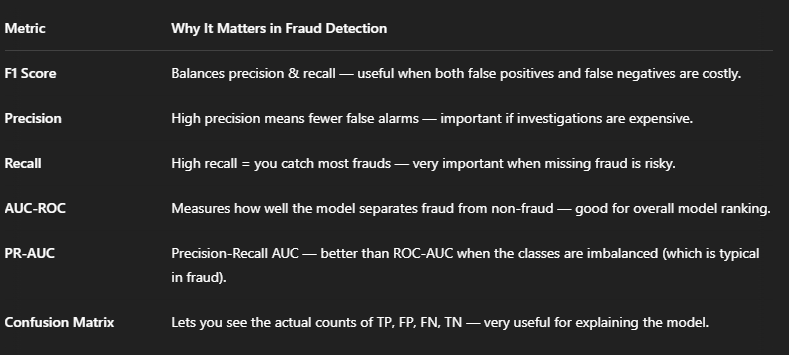

--> If the goal is to capture as many fraudulent cases as possible, then recall becomes the priority. This means you're okay with having more false positives, as long as fewer fraudulent cases are missed. You can increase recall by lowering the classification threshold.

--> On the other hand, if it's more important to avoid flagging legitimate transactions as fraud (to reduce customer friction or investigation costs), then precision should be prioritized. In this case, you can increase precision by raising the threshold to only flag the most confident fraud predictions.